# PROJECT 
#### Please refer to the attached historical data and propose a portfolio of 1 to 5 of the Eurostoxx 50 constituents which would best hedge a position of long 1,000 shares of Pernod Ricard.
#### Please include the following: 
#### 1) how you are defining what is the best hedge 
#### 2) an explanation of your approach compared with alternative methods 
#### 3) your selected hedges along with the number of shares of each 

# SOLUTION 
#### Solution 1 
If I define, a best hedge would be the minimum loss in the Value of long position of Pernod Ricard SA during the chosen time period for the hedge.
#### --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Solution 2 
Following are the steps I have taken to build my solution, also in each steps I have written down the difficulties/ambiguities (if any) I have faced :
1. Importing Libraries, Loading Data, Visualizing and Cleaning the data, Imputing Missing Values and Preparing the Dataframe for further evaluations.
2. From the historic data provided, following were studied, a) the closing price chart b) calculated daily returns chart c) two different correlation charts produced utilizing the closing price chart and the calculated daily returns chart. The next line of thought was to find negatively correlated stocks to Pernod which could be utilized to build a potfolio to hedge Pernod.
3. Correlation found from charts a) and b) showed no common constituents which were negatively correlated to Pernod Ricard SA.
4. Research was done to find why the two correlation tables showing completely different results. Using the learnings from the article PDF1 [see attached file with the solution email], it was concluded to find a time period where Pernod Ricard follows a trend such that it is more predictable to find the correlated constituents. Therefore, from the historic data, only last 116 days were considered to find correlations for Pernod with other stocks.
5. Again, the two correlation charts were studied for last 116 days, and the common stocks in both charts which were negatively correlated to Pernod were picked to further study their returns and covariance.
6. Another line of thought was to just pick all the combinations of 5 stocks out of 50 stocks without considering correlations because essentially the historic data for the whole year didn't really help to find the negatively correlated stocks to Pernod, then evaluate all these possible portfolios of combinations of 5 on their total risk but the computational power needed was not available with me.
7. Coming back to point 5, now for last 116 days, 12 constituents were found common in both the charts which were negatively correlated to Pernod. Then, Value at Risk (VAR) was calculated for Pernod at 95 percent confidence to find the maximum amount it would lose in next 116 days. 
8. Then, a minimum risk portfolio was simulated using convex optimization technique to find out worthy constitutents and their weights (therefore portfolio return) which would minimize the risk of the portfolio, at the same time the portfolio return using these weights could offset the VAR for Pernod.

My Approach and Alternative methods : I considered only long positions for all the negatively correlated constituents, the alternative could be shorting the positively correlated constituents to Pernod. I preferred long only positions, because shorting comes with inherent risk, and it was difficult to estimate risk of such positions considering data wasn't normally distributed. Also, one could utilize mean reversion techniques. One more possibility could be shorting Pernod itself to reduce some loss but the project asks to build portfolio from Eurostoxx constituents.

Other ways to improve or study the portfolio is to understand correlations calculation for closing price chart better by removing the trend component from the series (reference : https://quantdare.com/correlation-prices-returns/).
Also, improving the estimates for the calculation of risk (standard deviation) for 116 days, more weightage could be given to downside risk and use a better way to find total risk and not just by multiplying (Time)^0.5 [reference : PDF2 (see attached file with the solution email]

I also wasted alot of time building Markowitz efficient portfolio, which is not correct because the aim of the hedge is to reduce risk and not improve returns. Yes, if there was a range of risks given where we could operate, then finding larger returns make sense but in this project minimum risk will comply with only one return and the focus is to see if this return offset the VAR.
#### -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
#### Solution 3:
Following Portfolio (of 4 constituents, only long positions) was found to completely offset 95 percent VAR for Pernod Ricard SA (long 1000 shares) for the following 116 days considering normal distribution for returns:
AXA SA : 3126  
INTESA SANPAOLO : 15490
BAYERISCHE MOTOREN WERKE AG : 413
SIEMENS AG-REG : 208

Portfolio Weightage :
AXA SA : 47.28 %
INTESA SANPAOLO : 23.02 %
BAYERISCHE MOTOREN WERKE AG : 16.35 %
SIEMENS AG-REG : 13.34 %

Generally, managers try to hedge 5 to 10 percent of the losses in coming period for market fluctuations, therefore subsequent fractions as per risk capability could be taken for the hedge.
#### -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# DETAILED SOLUTION BELOW

# Importing Libraries

In [486]:
import missingno as msno 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
#import plotly.graph_objects as go
from sklearn.impute import KNNImputer
from itertools import chain, combinations, product

# Getting Data from Source File


In [487]:
#loading data from source
data = pd.read_excel("source_data.xlsx") 
data.head()

,Unnamed: 0,PERNOD RICARD SA,Unnamed: 2,L'OREAL,VINCI SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,ASML HOLDING NV,KONINKLIJKE PHILIPS NV,TELEFONICA SA,...,SIEMENS AG-REG,VOLKSWAGEN AG-PREF,MUENCHENER RUECKVER AG-REG,FRESENIUS SE & CO KGAA,SAP SE,ADIDAS AG,DEUTSCHE TELEKOM AG-REG,DEUTSCHE POST AG-REG,MERCEDES-BENZ GROUP AG,DEUTSCHE BOERSE AG
0,2019-02-14,149.00,NaN,220.5,79.10,5.028,3.9700,162.52,34.700,7.315,...,92.25,141.86,201.0,46.80,93.56,197.00,14.145,26.00,49.30,110.25
1,2019-02-15,150.55,NaN,221.8,80.52,5.194,4.1000,163.08,35.090,7.500,...,94.62,144.40,204.2,47.26,94.30,199.15,14.260,26.75,50.61,111.30
2,2019-02-18,150.00,NaN,224.7,80.46,5.227,4.1200,162.00,34.855,7.562,...,93.90,142.74,203.7,47.17,94.21,198.55,14.380,26.11,50.40,111.75
3,2019-02-19,149.45,NaN,223.1,80.28,5.189,4.0840,161.14,34.745,7.600,...,94.05,143.18,205.0,46.68,94.02,201.80,14.480,26.39,50.46,110.75
4,2019-02-20,151.00,NaN,224.4,81.04,5.237,4.1405,161.84,34.760,7.680,...,94.60,146.68,206.2,49.00,94.45,202.10,14.580,26.71,51.76,111.05


# Data Cleaning and Visualization

In [488]:
#Finding duplicated rows 
data.duplicated().sum() 

0

In [489]:
#looking for different column names i.e. Eurostoxx 50 constituents plus Pernod Ricard SA
data.columns 

Index(['Unnamed: 0', 'PERNOD RICARD SA', 'Unnamed: 2', 'L'OREAL', 'VINCI SA',
       'BANCO BILBAO VIZCAYA ARGENTA', 'BANCO SANTANDER SA', 'ASML HOLDING NV',
       'KONINKLIJKE PHILIPS NV', 'TELEFONICA SA', 'TOTAL SE', 'AIR LIQUIDE SA',
       'AXA SA', 'BNP PARIBAS', 'DANONE', 'VIVENDI SE', 'ESSILORLUXOTTICA',
       'LVMH MOET HENNESSY LOUIS VUI', 'KERING', 'AMADEUS IT GROUP SA',
       'SAFRAN SA', 'KONINKLIJKE AHOLD DELHAIZE N', 'UNILEVER PLC',
       'IBERDROLA SA', 'ING GROEP NV', 'LINDE PLC',
       'INDUSTRIA DE DISENO TEXTIL', 'INTESA SANPAOLO', 'ENI SPA', 'ENGIE',
       'ORANGE', 'ANHEUSER-BUSCH INBEV SA/NV', 'SANOFI', 'SOCIETE GENERALE SA',
       'ENEL SPA', 'NOKIA OYJ', 'SCHNEIDER ELECTRIC SE', 'ALLIANZ SE-REG',
       'AIRBUS SE', 'BAYER AG-REG', 'BAYERISCHE MOTOREN WERKE AG', 'CRH PLC',
       'BASF SE', 'SIEMENS AG-REG', 'VOLKSWAGEN AG-PREF',
       'MUENCHENER RUECKVER AG-REG', 'FRESENIUS SE & CO KGAA', 'SAP SE',
       'ADIDAS AG', 'DEUTSCHE TELEKOM AG-REG', 'DEUTSC

In [490]:
#Removing columns with no values
df = data.drop('Unnamed: 2',axis=1)
df.head(5)

,Unnamed: 0,PERNOD RICARD SA,L'OREAL,VINCI SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,ASML HOLDING NV,KONINKLIJKE PHILIPS NV,TELEFONICA SA,TOTAL SE,...,SIEMENS AG-REG,VOLKSWAGEN AG-PREF,MUENCHENER RUECKVER AG-REG,FRESENIUS SE & CO KGAA,SAP SE,ADIDAS AG,DEUTSCHE TELEKOM AG-REG,DEUTSCHE POST AG-REG,MERCEDES-BENZ GROUP AG,DEUTSCHE BOERSE AG
0,2019-02-14,149.00,220.5,79.10,5.028,3.9700,162.52,34.700,7.315,48.985,...,92.25,141.86,201.0,46.80,93.56,197.00,14.145,26.00,49.30,110.25
1,2019-02-15,150.55,221.8,80.52,5.194,4.1000,163.08,35.090,7.500,49.695,...,94.62,144.40,204.2,47.26,94.30,199.15,14.260,26.75,50.61,111.30
2,2019-02-18,150.00,224.7,80.46,5.227,4.1200,162.00,34.855,7.562,49.510,...,93.90,142.74,203.7,47.17,94.21,198.55,14.380,26.11,50.40,111.75
3,2019-02-19,149.45,223.1,80.28,5.189,4.0840,161.14,34.745,7.600,49.510,...,94.05,143.18,205.0,46.68,94.02,201.80,14.480,26.39,50.46,110.75
4,2019-02-20,151.00,224.4,81.04,5.237,4.1405,161.84,34.760,7.680,49.630,...,94.60,146.68,206.2,49.00,94.45,202.10,14.580,26.71,51.76,111.05


In [491]:
#Renaming the Column 'Unnamed: 0' to 'Date' 
df1 = df.rename(columns = {'Unnamed: 0':'Date'})
df1.set_index('Date', inplace=True)
df1

,PERNOD RICARD SA,L'OREAL,VINCI SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,ASML HOLDING NV,KONINKLIJKE PHILIPS NV,TELEFONICA SA,TOTAL SE,AIR LIQUIDE SA,...,SIEMENS AG-REG,VOLKSWAGEN AG-PREF,MUENCHENER RUECKVER AG-REG,FRESENIUS SE & CO KGAA,SAP SE,ADIDAS AG,DEUTSCHE TELEKOM AG-REG,DEUTSCHE POST AG-REG,MERCEDES-BENZ GROUP AG,DEUTSCHE BOERSE AG
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-14,149.00,220.5,79.100000,5.028,3.9700,162.520000,34.700000,7.315,48.985,96.363636,...,92.250000,141.860000,201.000000,46.800,93.560000,197.00,14.145,26.000000,49.300,110.25
2019-02-15,150.55,221.8,80.520000,5.194,4.1000,163.080000,35.090000,7.500,49.695,97.136364,...,94.620000,144.400000,204.200000,47.260,94.300000,199.15,14.260,26.750000,50.610,111.30
2019-02-18,150.00,224.7,80.460000,5.227,4.1200,162.000000,34.855000,7.562,49.510,97.272727,...,93.900000,142.740000,203.700000,47.170,94.210000,198.55,14.380,26.110000,50.400,111.75
2019-02-19,149.45,223.1,80.280000,5.189,4.0840,161.140000,34.745000,7.600,49.510,97.090909,...,94.050000,143.180000,205.000000,46.680,94.020000,201.80,14.480,26.390000,50.460,110.75
2019-02-20,151.00,224.4,81.040000,5.237,4.1405,161.840000,34.760000,7.680,49.630,98.363636,...,94.600000,146.680000,206.200000,49.000,94.450000,202.10,14.580,26.710000,51.760,111.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-10,160.80,270.8,104.400000,5.242,3.8365,281.000000,44.345000,6.177,44.575,134.650000,...,108.300000,164.380000,277.500000,48.600,123.660000,286.05,14.864,32.525000,43.045,153.00
2020-02-11,160.00,273.0,105.000000,5.233,3.8700,288.450000,44.605000,6.170,44.990,137.900000,...,109.440000,167.440000,277.400000,49.155,125.360000,286.80,15.422,32.965000,42.635,153.65
2020-02-12,160.65,271.1,105.650000,5.329,3.9550,290.750000,44.865000,6.330,45.485,138.800000,...,109.580000,173.140000,278.600000,49.090,126.820000,290.70,15.612,33.230000,43.995,153.25


<AxesSubplot:>

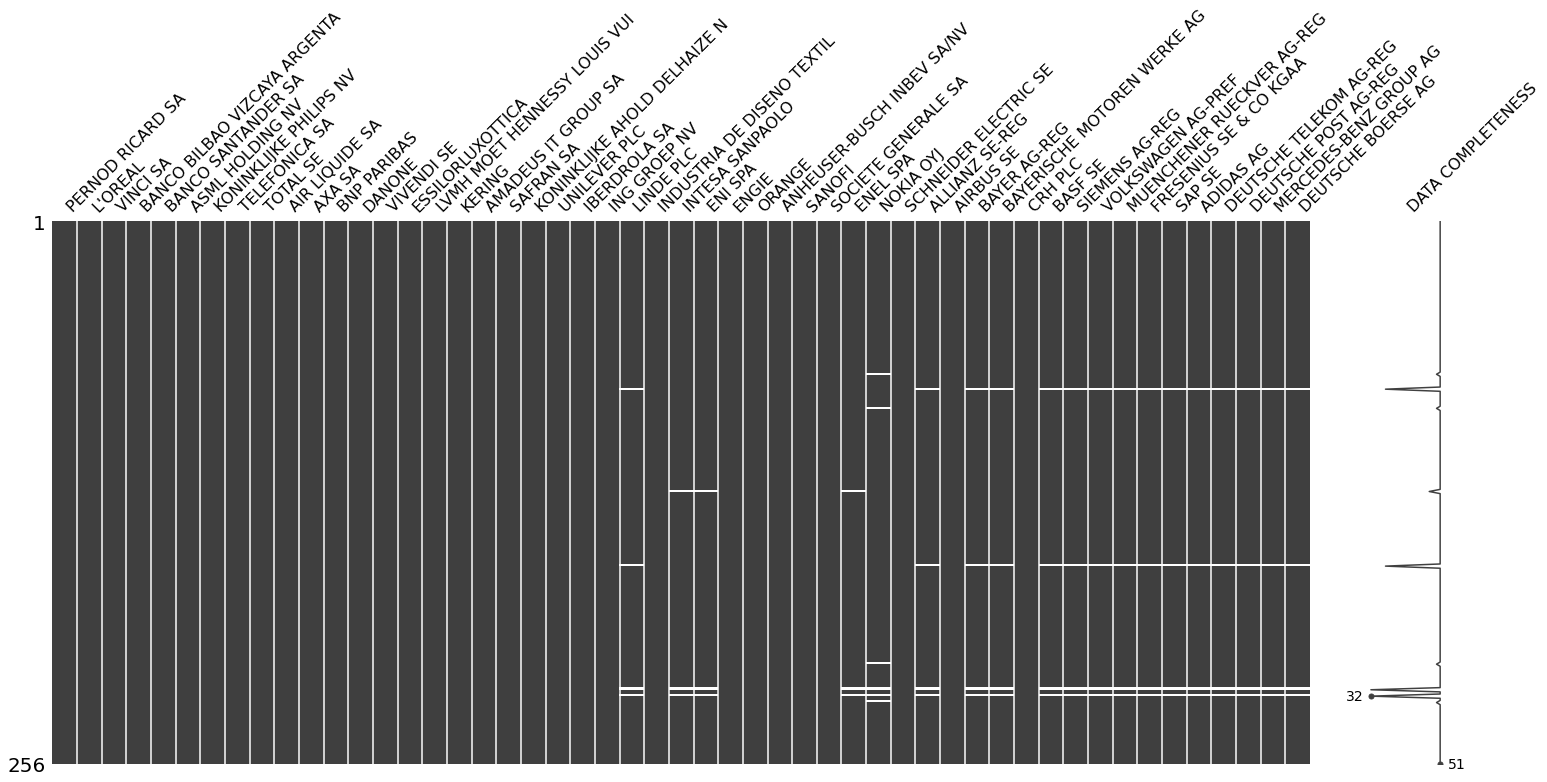

In [492]:
#Visualizing the missing values
msno.matrix(df1,labels=True)

In [493]:
#Finding reasons why there are dates on which many company's stocks were untradable
df1[df1.isna().any(axis=1)]
#found mostly end of the year

,PERNOD RICARD SA,L'OREAL,VINCI SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,ASML HOLDING NV,KONINKLIJKE PHILIPS NV,TELEFONICA SA,TOTAL SE,AIR LIQUIDE SA,...,SIEMENS AG-REG,VOLKSWAGEN AG-PREF,MUENCHENER RUECKVER AG-REG,FRESENIUS SE & CO KGAA,SAP SE,ADIDAS AG,DEUTSCHE TELEKOM AG-REG,DEUTSCHE POST AG-REG,MERCEDES-BENZ GROUP AG,DEUTSCHE BOERSE AG
Date,,,,,,,,,,,,,,,,,,,,,
2019-05-30,161.80,241.9,88.82,5.0750,4.0500,170.98,35.940,7.216,46.840,102.681818,...,103.12,143.22,219.3,46.105,112.00,258.25,15.204,26.725,47.300,125.35
2019-06-10,159.40,245.2,90.54,5.0680,4.0375,175.00,36.035,7.459,48.250,105.545455,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-06-21,162.80,255.3,91.04,4.9175,4.0005,178.70,38.045,7.264,49.115,111.227273,...,105.74,147.18,225.4,48.190,118.50,268.80,15.412,28.390,49.620,126.80
2019-08-15,156.85,230.3,93.48,4.2340,3.4745,188.06,40.950,5.945,43.300,110.454545,...,85.00,138.16,215.5,41.750,105.74,257.10,14.648,28.230,40.530,127.25
2019-10-03,169.35,242.6,95.40,4.5190,3.5085,220.60,40.355,6.767,44.910,113.681818,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-06,163.20,256.7,98.24,4.7830,3.5850,252.60,42.610,6.868,47.955,122.400000,...,116.80,176.60,259.4,49.420,122.20,279.20,15.064,34.080,49.455,137.40
2019-12-24,162.55,264.5,98.76,5.0610,3.7550,264.90,44.040,6.412,49.475,126.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-31,159.40,264.0,99.00,4.9830,3.7300,263.70,43.520,6.227,49.200,126.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-06,161.20,263.0,98.72,5.0320,3.7745,263.10,43.535,6.345,50.440,125.450000,...,115.82,176.62,262.7,49.365,119.56,289.65,14.578,33.625,48.805,138.35


Text(0.5, 1.0, 'Quantifying missing data')

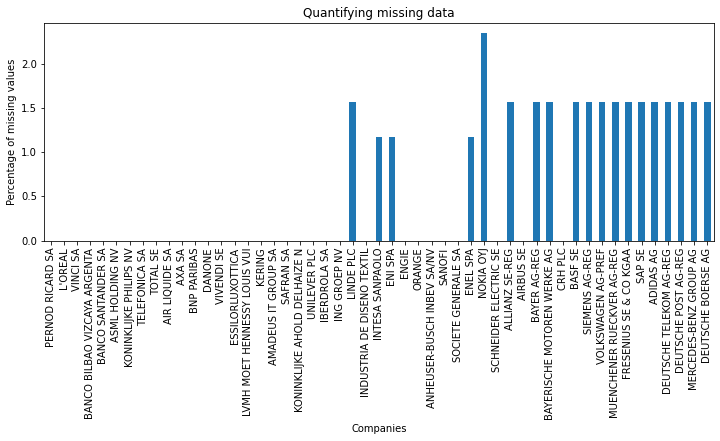

In [494]:
#Percentage of missing values per column
df2 = (df1.isnull().sum()/len(df1))*100
df2.plot(kind='bar', figsize=(12,4))
plt.ylabel('Percentage of missing values')
plt.xlabel('Companies')
plt.title('Quantifying missing data')

## Imputing Missing Values and Preparing the Final DataFrame

### Since maximimum missing value % for any column is less than 3 percent, a way forward could be their imputation.
### Time series data with very less % of missing values -> it's better to impute than deleting rows with missing values.
### Missing Values Imputation below is carried out using KNN Imputer.
### It will find given 'n' number of similar(close) non empty samples utilizing other features to compute missing values.
### It will find similar movements in the prices comparing its correlated variables and estimate the missing value.

In [495]:
imputeknn = KNNImputer(n_neighbors=5) #5 nearby correlated samples are chosen

#Below gives dataframe with imputed values
df3 = pd.DataFrame(imputeknn.fit_transform(df1), columns = df1.columns, index = df1.index)

#Visualizing two graphs one with missing value and other with imputed value
fig1 = px.line(df1, x=df1.index, y="NOKIA OYJ", title = "With Missing Values")
fig1.show()
fig2 = px.line(df3, x=df3.index, y="NOKIA OYJ", title = "With Imputed Values")
fig2.show()

### All the stocks which had missing values were checked for change in variance before and after the imputation and they were fairly stable. Therefore, this method of imputation is accepted.

## DATAFRAME

In [496]:
#Final Closing Price DataFrame using 1 year data
df3

,PERNOD RICARD SA,L'OREAL,VINCI SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,ASML HOLDING NV,KONINKLIJKE PHILIPS NV,TELEFONICA SA,TOTAL SE,AIR LIQUIDE SA,...,SIEMENS AG-REG,VOLKSWAGEN AG-PREF,MUENCHENER RUECKVER AG-REG,FRESENIUS SE & CO KGAA,SAP SE,ADIDAS AG,DEUTSCHE TELEKOM AG-REG,DEUTSCHE POST AG-REG,MERCEDES-BENZ GROUP AG,DEUTSCHE BOERSE AG
Date,,,,,,,,,,,,,,,,,,,,,
2019-02-14,149.00,220.5,79.100000,5.028,3.9700,162.520000,34.700000,7.315,48.985,96.363636,...,92.250000,141.860000,201.000000,46.800,93.560000,197.00,14.145,26.000000,49.300,110.25
2019-02-15,150.55,221.8,80.520000,5.194,4.1000,163.080000,35.090000,7.500,49.695,97.136364,...,94.620000,144.400000,204.200000,47.260,94.300000,199.15,14.260,26.750000,50.610,111.30
2019-02-18,150.00,224.7,80.460000,5.227,4.1200,162.000000,34.855000,7.562,49.510,97.272727,...,93.900000,142.740000,203.700000,47.170,94.210000,198.55,14.380,26.110000,50.400,111.75
2019-02-19,149.45,223.1,80.280000,5.189,4.0840,161.140000,34.745000,7.600,49.510,97.090909,...,94.050000,143.180000,205.000000,46.680,94.020000,201.80,14.480,26.390000,50.460,110.75
2019-02-20,151.00,224.4,81.040000,5.237,4.1405,161.840000,34.760000,7.680,49.630,98.363636,...,94.600000,146.680000,206.200000,49.000,94.450000,202.10,14.580,26.710000,51.760,111.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-10,160.80,270.8,104.400000,5.242,3.8365,281.000000,44.345000,6.177,44.575,134.650000,...,108.300000,164.380000,277.500000,48.600,123.660000,286.05,14.864,32.525000,43.045,153.00
2020-02-11,160.00,273.0,105.000000,5.233,3.8700,288.450000,44.605000,6.170,44.990,137.900000,...,109.440000,167.440000,277.400000,49.155,125.360000,286.80,15.422,32.965000,42.635,153.65
2020-02-12,160.65,271.1,105.650000,5.329,3.9550,290.750000,44.865000,6.330,45.485,138.800000,...,109.580000,173.140000,278.600000,49.090,126.820000,290.70,15.612,33.230000,43.995,153.25


In [497]:
#Closing Price Time Series for Pernod Ricard SA
fig3 = px.line(df3, x=df3.index, y="PERNOD RICARD SA", title = "Closing Price Time Series")
fig3.show()

### The project asks to hedge PERNOD RICARD SA's long position, Initially I tried to find negatively correlated stocks to Pernod's to buid a portfolio considering the enitre timeline given in the data source(i.e. 1 year) using both price and simple daily returns(also log return) chart.
### Problem arises when when both the correlation charts suggests different results. 
### In such cases, most research articles conclude with saying there is no perfect rule to determine which correlation chart could be more useful even though generally returns chart has an upper hand just because of its stationarity property.
### It can be seen from the above graph that PERNOD RICARD SA closing prices starts to follow downward trend with some seasonality (which was not evident before, hence more intuitive to predict ahead) from date 3rd September 2019 onwards, therefore I considered 116 days of data from 3rd sept 2019 to build correlation charts using closing prices and simple daily returns.

## DATAFRAME below will be used for further calculations

In [498]:
#Dataframe using last 116 days of Closing Price
df4 = df3.tail(116)
df4.head()

,PERNOD RICARD SA,L'OREAL,VINCI SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,ASML HOLDING NV,KONINKLIJKE PHILIPS NV,TELEFONICA SA,TOTAL SE,AIR LIQUIDE SA,...,SIEMENS AG-REG,VOLKSWAGEN AG-PREF,MUENCHENER RUECKVER AG-REG,FRESENIUS SE & CO KGAA,SAP SE,ADIDAS AG,DEUTSCHE TELEKOM AG-REG,DEUTSCHE POST AG-REG,MERCEDES-BENZ GROUP AG,DEUTSCHE BOERSE AG
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-03,177.25,252.9,99.98,4.286,3.3985,201.25,42.900,6.372,44.775,113.954545,...,89.87,146.28,219.7,44.410,108.30,270.40,15.192,29.670,43.025,137.20
2019-09-04,176.55,254.8,100.70,4.313,3.4070,204.70,42.985,6.437,45.405,114.454545,...,91.20,147.96,221.7,44.665,109.22,273.05,15.196,29.945,43.970,137.95
2019-09-05,174.60,250.7,100.90,4.496,3.5270,215.10,42.965,6.507,46.225,113.000000,...,91.55,150.84,222.2,44.620,111.48,274.80,15.080,30.385,45.350,136.25
2019-09-06,174.75,251.2,99.86,4.490,3.5310,217.30,43.055,6.582,45.780,113.909091,...,92.55,150.40,223.2,44.650,111.30,278.90,15.092,30.485,45.405,137.40
2019-09-09,168.65,249.3,97.88,4.602,3.6165,219.15,42.140,6.660,46.325,112.318182,...,94.19,154.08,226.8,44.200,110.20,277.05,15.034,30.465,46.450,136.10


### Finding Simple Daily Returns

In [499]:
#Simple Daily Returns
Simple_daily_returns = df4.pct_change().dropna()
Simple_daily_returns.head()

,PERNOD RICARD SA,L'OREAL,VINCI SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,ASML HOLDING NV,KONINKLIJKE PHILIPS NV,TELEFONICA SA,TOTAL SE,AIR LIQUIDE SA,...,SIEMENS AG-REG,VOLKSWAGEN AG-PREF,MUENCHENER RUECKVER AG-REG,FRESENIUS SE & CO KGAA,SAP SE,ADIDAS AG,DEUTSCHE TELEKOM AG-REG,DEUTSCHE POST AG-REG,MERCEDES-BENZ GROUP AG,DEUTSCHE BOERSE AG
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-04,-0.003949,0.007513,0.007201,0.006300,0.002501,0.017143,0.001981,0.010201,0.014070,0.004388,...,0.014799,0.011485,0.009103,0.005742,0.008495,0.009800,0.000263,0.009269,0.021964,0.005466
2019-09-05,-0.011045,-0.016091,0.001986,0.042430,0.035222,0.050806,-0.000465,0.010875,0.018060,-0.012708,...,0.003838,0.019465,0.002255,-0.001008,0.020692,0.006409,-0.007634,0.014694,0.031385,-0.012323
2019-09-06,0.000859,0.001994,-0.010307,-0.001335,0.001134,0.010228,0.002095,0.011526,-0.009627,0.008045,...,0.010923,-0.002917,0.004500,0.000672,-0.001615,0.014920,0.000796,0.003291,0.001213,0.008440
2019-09-09,-0.034907,-0.007564,-0.019828,0.024944,0.024214,0.008514,-0.021252,0.011851,0.011905,-0.013966,...,0.017720,0.024468,0.016129,-0.010078,-0.009883,-0.006633,-0.003843,-0.000656,0.023015,-0.009461
2019-09-10,-0.002965,-0.004813,-0.002043,0.020426,0.028757,-0.009582,-0.003322,0.003904,0.022666,0.008499,...,0.019216,0.003505,0.004850,0.017081,-0.013249,-0.025988,0.001197,0.010340,0.008611,-0.004409


In [500]:
#Simple Daily Return Time Series for Pernod Ricard SA
fig4 = px.line(Simple_daily_returns, x=Simple_daily_returns.index, y="PERNOD RICARD SA", title = "Simple Daily Return")
fig4.show()

# Correlation 

### To find Negatively Correlated Stocks to PERNOD RICARD SA common in both closing price and simple daily return correlation chart.
### The reason behind doing this is to be extremely sure of the stocks which exhibits definitely a negatively correlation.

In [501]:
#Negative Correlations from closing price dataframe
corr_ClosingPrice = df4.corr()
df5 = corr_ClosingPrice.loc[corr_ClosingPrice['PERNOD RICARD SA'] <0]

#Negative Correlations from simple daily return dataframe
corr_DailyReturns = Simple_daily_returns.corr()
df6 = corr_DailyReturns.loc[corr_DailyReturns['PERNOD RICARD SA'] <0]

#Stocks common in both the above set which are negatively correlated to PERNOD
idx = df5.index.intersection(df6.index)

#To make it a list of all stocks negatively correlated to PERNOD
list_stocks = idx.tolist()
list_stocks

['BANCO BILBAO VIZCAYA ARGENTA',
 'BANCO SANTANDER SA',
 'AXA SA',
 'BNP PARIBAS',
 'ING GROEP NV',
 'INTESA SANPAOLO',
 'SOCIETE GENERALE SA',
 'BAYERISCHE MOTOREN WERKE AG',
 'BASF SE',
 'SIEMENS AG-REG',
 'VOLKSWAGEN AG-PREF',
 'MERCEDES-BENZ GROUP AG']

Text(0.5, 1.0, 'Negatively correlated Stocks with Pernod Ricard SA')

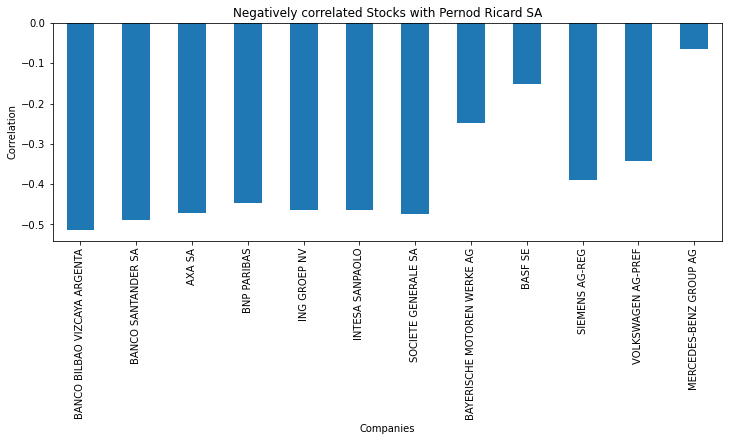

In [502]:
#Bar chart to represent negative correlation of stocks with Pernod Ricard SA
df7 = df4[['PERNOD RICARD SA']+list_stocks]
df8 = df7.corr()
df8['PERNOD RICARD SA'][1:].plot(kind='bar', figsize=(12,4))
plt.ylabel('Correlation')
plt.xlabel('Companies')
plt.title('Negatively correlated Stocks with Pernod Ricard SA')

### The above study suggests that out of Eurostoxx 50 companies there are 6 banking and financial services companies, 1 insurance company, 3 car manufacturing companies, 1 chemical product company and 1 industrial product company; which are negatively correlated to RICARD PERNOD SA.

### To visualise correlation between Pernod and Volkswagen using closing price chart.
#### Volkswagen is chosen for the below graph because its share price is comparable to Pernod Ricard which makes it easier to visualize how they evolve together.

In [503]:
fig5 = px.line(df4, x=df4.index, y=["PERNOD RICARD SA","VOLKSWAGEN AG-PREF"], title = "Closing Price Time Series")
fig5.show()

# Building Portfolio

## In the project it has been asked to build a portfolio of 1 to 5 constituents from EuroStoxx 50, and after studying negatively correlated stocks to Pernod, now we are down to 12 constituents. Keeping in mind the diversification given all the 12 constitutents are neither very highly negatively correlated to Pernod, for meanwhile it would be good to see how a portfolio of 13 companies (Pernod plus 12 others which are negatively correlated) help reduce the risk.


# Portfolio Constituent's Returns, Risk and Covariance for last 116 days

In [504]:
#Portfolio Constituents Simple Daily Returns
Port = ['PERNOD RICARD SA','BANCO BILBAO VIZCAYA ARGENTA',
 'BANCO SANTANDER SA',
 'AXA SA',
 'BNP PARIBAS',
 'ING GROEP NV',
 'INTESA SANPAOLO',
 'SOCIETE GENERALE SA',
 'BAYERISCHE MOTOREN WERKE AG',
 'BASF SE',
 'SIEMENS AG-REG',
 'VOLKSWAGEN AG-PREF',
 'MERCEDES-BENZ GROUP AG']
Port_Simple_Daily_Returns = df7[Port].pct_change().dropna()
Port_Simple_Daily_Returns.head() 

,PERNOD RICARD SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,AXA SA,BNP PARIBAS,ING GROEP NV,INTESA SANPAOLO,SOCIETE GENERALE SA,BAYERISCHE MOTOREN WERKE AG,BASF SE,SIEMENS AG-REG,VOLKSWAGEN AG-PREF,MERCEDES-BENZ GROUP AG
Date,,,,,,,,,,,,,
2019-09-04,-0.003949,0.006300,0.002501,0.010091,0.010038,0.013993,0.013497,0.016757,0.011424,0.014319,0.014799,0.011485,0.021964
2019-09-05,-0.011045,0.042430,0.035222,0.018316,0.029209,0.030338,0.014057,0.034889,0.020134,0.013287,0.003838,0.019465,0.031385
2019-09-06,0.000859,-0.001335,0.001134,0.007241,-0.000236,0.005424,0.005350,-0.001034,0.000000,0.007376,0.010923,-0.002917,0.001213
2019-09-09,-0.034907,0.024944,0.024214,0.018785,0.029682,0.027634,0.016691,0.040994,0.014442,0.013342,0.017720,0.024468,0.023015
2019-09-10,-0.002965,0.020426,0.028757,0.015252,0.019218,0.025070,0.010469,0.016110,0.008700,0.025530,0.019216,0.003505,0.008611


In [505]:
#Portfolio Contituents Returns for last 116 days
Returns = (1+Port_Simple_Daily_Returns.mean())**116 - 1
Returns.head()

PERNOD RICARD SA               -0.056162
BANCO BILBAO VIZCAYA ARGENTA    0.249337
BANCO SANTANDER SA              0.183363
AXA SA                          0.229932
BNP PARIBAS                     0.337263
dtype: float64

In [506]:
#Portfolio Constitutents Risk for last 116 days
Risk = Port_Simple_Daily_Returns.std()*(np.sqrt(116))
Risk.head()

PERNOD RICARD SA                0.132039
BANCO BILBAO VIZCAYA ARGENTA    0.163422
BANCO SANTANDER SA              0.193756
AXA SA                          0.103807
BNP PARIBAS                     0.146107
dtype: float64

In [507]:
#Portfolio Constituents Covariance for last 116 days
Cov = Port_Simple_Daily_Returns.cov()*116
Cov

,PERNOD RICARD SA,BANCO BILBAO VIZCAYA ARGENTA,BANCO SANTANDER SA,AXA SA,BNP PARIBAS,ING GROEP NV,INTESA SANPAOLO,SOCIETE GENERALE SA,BAYERISCHE MOTOREN WERKE AG,BASF SE,SIEMENS AG-REG,VOLKSWAGEN AG-PREF,MERCEDES-BENZ GROUP AG
PERNOD RICARD SA,0.017434,-0.002135,-0.003941,-0.000947,-0.002421,-0.002359,-0.001462,-0.003605,-0.001728,-0.001623,-0.000905,-0.001339,-0.003197
BANCO BILBAO VIZCAYA ARGENTA,-0.002135,0.026707,0.027330,0.011372,0.019690,0.021038,0.014073,0.019579,0.011530,0.012359,0.008802,0.012790,0.015295
BANCO SANTANDER SA,-0.003941,0.027330,0.037541,0.013894,0.023179,0.024663,0.016776,0.024111,0.014488,0.016778,0.013568,0.016723,0.018711
AXA SA,-0.000947,0.011372,0.013894,0.010776,0.011373,0.011724,0.007514,0.011935,0.007423,0.008901,0.007625,0.009345,0.009876
BNP PARIBAS,-0.002421,0.019690,0.023179,0.011373,0.021347,0.019597,0.012475,0.020292,0.011650,0.011807,0.010367,0.014380,0.013489
ING GROEP NV,-0.002359,0.021038,0.024663,0.011724,0.019597,0.023215,0.013560,0.020864,0.012533,0.013565,0.010766,0.015685,0.016369
INTESA SANPAOLO,-0.001462,0.014073,0.016776,0.007514,0.012475,0.013560,0.013617,0.013006,0.008288,0.009179,0.007591,0.010521,0.012164
SOCIETE GENERALE SA,-0.003605,0.019579,0.024111,0.011935,0.020292,0.020864,0.013006,0.025456,0.014552,0.012602,0.010755,0.017141,0.015504
BAYERISCHE MOTOREN WERKE AG,-0.001728,0.011530,0.014488,0.007423,0.011650,0.012533,0.008288,0.014552,0.015683,0.009905,0.008051,0.015401,0.014498
BASF SE,-0.001623,0.012359,0.016778,0.008901,0.011807,0.013565,0.009179,0.012602,0.009905,0.015594,0.010791,0.012739,0.013689


# METHOD 1 : Include Pernod Ricard SA and 12 other constituents which were negatively correlated to Pernod in one Portfolio and minimize the risk of this portfolio. Later decide on the top 5 constituents.

# To hedge Pernod Ricard SA, it is necessary to minimize the risk of the portfolio as a whole (considering only Long Positions)

## It is a convex optimization problem to minimize Risk (or in this case portfolio variance) where weights of all the constituents in the portfolio sum upto 1 and each of the weights should be greater or equal to zero.

In [508]:
#CVXPY is an open source Python-embedded modeling language for convex optimization problems
from cvxpy import *
import cvxpy as cvx
#group_constraint_control = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_variables = len(Returns)
minimum_values = np.zeros(len(Returns)) 
weights_cvx = cvx.Variable(n_variables) 
#Func_Port_Variance2 = cvx.sum(re * weights_cvx)
#Func_Port_Variance = np.dot((np.array(weights_cvx)).T, np.dot(np.asmatrix(Cov),(weights_cvx)))
Func_Port_Variance = quad_form(weights_cvx, np.asmatrix(Cov))
weights_sum_equal_one = cvx.sum(weights_cvx) == 1
weights_greater_than_or_Equal_zero = weights_cvx >= minimum_values
#Pernod_weight_value = group_constraint_control@weights_cvx >= 0.9
 
constraints = [
    weights_sum_equal_one,
    weights_greater_than_or_Equal_zero,
    #Pernod_weight_value
]

                            
objective = cvx.Minimize(Func_Port_Variance)
prob = cvx.Problem(objective, constraints)
prob.solve(verbose=True)
 
print("weights: {}".format(
    ', '.join(['{:.2%}'.format(x) for x in weights_cvx.value])
))

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Sep 16 04:07:05 PM: Your problem has 13 variables, 2 constraints, and 0 parameters.
(CVXPY) Sep 16 04:07:05 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 16 04:07:05 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 16 04:07:05 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 16 04:07:05 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 16 04:07:05 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

## Found that following weights for constituents that execute the minimum portfolio risk :
 ### 'PERNOD RICARD SA' :35.57%
 ### 'AXA SA' :27.94%
 ### 'INTESA SANPAOLO' :16.16%
 ### 'BAYERISCHE MOTOREN WERKE AG' :12.81%
 ### 'SIEMENS AG-REG' : 7.52%

# Portfolio Risk

In [509]:
weights = weights_cvx.value
Func_Port_Variance1 = np.dot((np.array(weights)).T, np.dot(Cov,weights))
Port_Risk = round((np.sqrt(Func_Port_Variance1)),4)
Port_Risk

0.0736

# Value At Risk (VAR)
# Value exposed to Market fluctuations
## VAR is a good measure to evaluate if the hedging portfolio formulated actually reduces the value at risk or not.
## VAR = z_score_cut_off * period_standard_deviation * initial_investment
## Considering Normal distribution of Stocks return, 95% confidence interval will give Z_score_cutoff as approx. 1.645
## The given project mentions that Pernod Ricard SA is a long position with 1000 shares. This means if bought on 14/02/2020 (last day of the historic data given), the total investment would be 165.95 * 1000 = 165950. Calculated risk on Pernod is 13.2 percent, there VAR for Pernod is 1.645 * 0.132 * 165950 = 36034.383

## This means there is 95 percent probability that Pernod will not lose more than 36034.383 (21.71% of its initial value) in the next 116 days.

# Hedged Portfolio Value at Risk

## There is 95 percent confidence that Porfolio (with risk 7.36 percent calculated above) will not lose more that (0.0736 * 1.645 * 100) = 12.11 % of its initial value in the next 116 days.
## Therefore, clearly hedging reduces the overall risk by 9.6 percent.

# XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

# Theoritically the above solution has a meaning but in reality one doesn't want to put almost 2 times the original investment (since Pernod weight is 35 %) to hedge the current position.

# Therefore I believe the above solution has only theoritical significance.

# METHOD 2 : To build a portfolio with 12 constituents (which were negatively correlated to Pernod) and find their weights, such that its returns would offset (if possible completely) the VAR of Pernod. Then later choosing top constituents via solver.

# Portfolio of Hedging Constituents

In [510]:
#Stocks (negatively correlated with Pernod Ricard SA) Closing Price
Stocks_CP = df4[list_stocks]
#Stocks daily returns
Stocks_Daily_returns = Stocks_CP.pct_change().dropna()
#Stocks Returns for last 116 days
Stocks_Returns = (1+Stocks_Daily_returns.mean())**116 - 1
#Stocks Covariance for last 116 days
Stocks_Cov = Stocks_Daily_returns.cov()*116

# To completely Hedge Pernod for next 116 days, let's find the weights for the minimum risk portfolio, such that we are very sure that there exist no other lesser risk portfolio which could completely hedge Pernod. (considering only long position)

In [511]:
#group_constraint_control = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
n_variables1 = len(Stocks_Returns)
minimum_values1 = np.zeros(len(Stocks_Returns)) 
weights_cvx1 = cvx.Variable(n_variables1) 
#Func_Port_Variance2 = cvx.sum(re * weights_cvx)
#Func_Port_Variance = np.dot((np.array(weights_cvx)).T, np.dot(np.asmatrix(Cov),(weights_cvx)))
Func_Port_Variance2 = quad_form(weights_cvx1, np.asmatrix(Stocks_Cov))
weights_sum_equal_one1 = cvx.sum(weights_cvx1) == 1
weights_greater_than_or_Equal_zero1 = weights_cvx1 >= minimum_values1
#Pernod_weight_value = group_constraint_control@weights_cvx >= 0.9
 
constraints1 = [
    weights_sum_equal_one1,
    weights_greater_than_or_Equal_zero1,
    #Pernod_weight_value
]

                            
objective1 = cvx.Minimize(Func_Port_Variance2)
prob1 = cvx.Problem(objective1, constraints1)
prob1.solve(verbose=True)
 
print("weights: {}".format(
    ', '.join(['{:.2%}'.format(x) for x in weights_cvx1.value])
))

                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Sep 16 04:07:06 PM: Your problem has 12 variables, 2 constraints, and 0 parameters.
(CVXPY) Sep 16 04:07:06 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Sep 16 04:07:06 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Sep 16 04:07:06 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Sep 16 04:07:06 PM: Compiling problem (target solver=OSQP).
(CVXPY) Sep 16 04:07:06 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

# Portfolio of 4 constituents which would completely hedge Pernod given the investment on the new Portfolio

### AXA SA : 47.28 %
### INTESA SANPAOLO : 23.02 %
### BAYERISCHE MOTOREN WERKE AG : 16.35 %
### SIEMENS AG-REG : 13.34 %

# Portfolio (with minimum risk) Return

In [512]:
Port2_Return = np.dot(weights1,Stocks_Returns)
Port2_Return 

0.21441768507547107

# Let suppose we want to completely offset VAR (95% Confident) for Pernod then we want the return (amount) of the minimum risk portfolio to be equal to 36034.383 

# Investment (for complete hedge) Needed

In [513]:
Investment_Hedge = 36034.383/(Port2_Return)
Investment_Hedge

168056.9538250381

# To Find Shares of Different Portfolio Constituents needed for complete hedge

### Share Price for different constituents at the last observed day in the given historic data :


In [514]:
New_Port = ['AXA SA', 'INTESA SANPAOLO', 'BAYERISCHE MOTOREN WERKE AG', 'SIEMENS AG-REG']
df4[New_Port].tail(1)

,AXA SA,INTESA SANPAOLO,BAYERISCHE MOTOREN WERKE AG,SIEMENS AG-REG
Date,,,,
2020-02-14,25.415001,2.4975,66.470001,107.620003


In [515]:
AXA_SA_Shares = 0.4728 * Investment_Hedge/25.415001
np.round(AXA_SA_Shares)

3126.0

In [516]:
INTESA_SANPAOLO_Shares = 0.2302 * Investment_Hedge/2.4975
np.round(INTESA_SANPAOLO_Shares)

15490.0

In [517]:
BAYERISCHE_MOTOREN_WERKE_AG_Shares = 0.1635 * Investment_Hedge/66.470001
np.round(BAYERISCHE_MOTOREN_WERKE_AG_Shares)

413.0

In [518]:
SIEMENS_AG_REG_Shares = 0.1334 * Investment_Hedge/107.620003
np.round(SIEMENS_AG_REG_Shares)

208.0

# Number of shares for different Portfolio Constituents to completely hedge Pernod's VAR for the period of upcoming 116 days considering long only position :

## AXA SA : 3126
## INTESA SANPAOLO : 15490
## BAYERISCHE MOTOREN WERKE AG : 413
## SIEMENS AG-REG : 208

# ---------------------------------------------------------------------------------------------------------------